# PART |

### Table of content:

#### 1. Unit testing
#### 2. Data visualization
#### 3. Model identification
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; &nbsp;3.1 Velocity-based models
        3.1.1 MLP
        3.1.2 Gradient Boost
#### 4. Models evaluation
        3.1 MLP
        3.2 Gradient Boost
#### 5. Model verification
    5.1 Integrating predictions (Multi-step ahead)
    5.2 Building 2d Simulator based on learned Model

In [2]:
import sys
sys.path.append('..')

In [5]:
import pixiedust
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from pyquaternion import Quaternion 
from Utilities import *

In [6]:
%matplotlib inline
np.random.seed=1

# Dataset:
## Dataset is colleced at 10hz using Microsoft AirSim
average linear and angular velocities are used to train the model

<img src='airsim.gif'>

In [7]:
path1 = '../datasets/10hz.csv'
dataset = pd.read_csv(path1)

length, width = dataset.shape

In [8]:
length

35631

### Dataset consist of 35631 training instances collected over 1 hour

#### Data is split in to train/test datasets 80%, 20%

In [9]:
limit = length
train = int(0.8 * limit)

X, y = getXyVelocityModel(dataset, limit=limit, frequency=10.0)
xTrain, xTest, yTrain, yTest = X[:train], X[train:], y[:train], y[train:] 

#### Model Inputs

In [10]:
X.columns

Index(['dXB', 'dYB', 'dZB', 'dRoll', 'dPitch', 'dYaw', 'roll', 'pitch',
       'moveForward', 'yawCCW', 'yawCW', 'hover'],
      dtype='object')

#### Model outputs

In [11]:
y.columns

Index(['dXB', 'dYB', 'dZB', 'dRoll', 'dPitch', 'dYaw'], dtype='object')

In [12]:
plot_limit = 300
frequency = 10.0

## Unit test (rotations, numerical integration, data verification)

Unit test passed!!


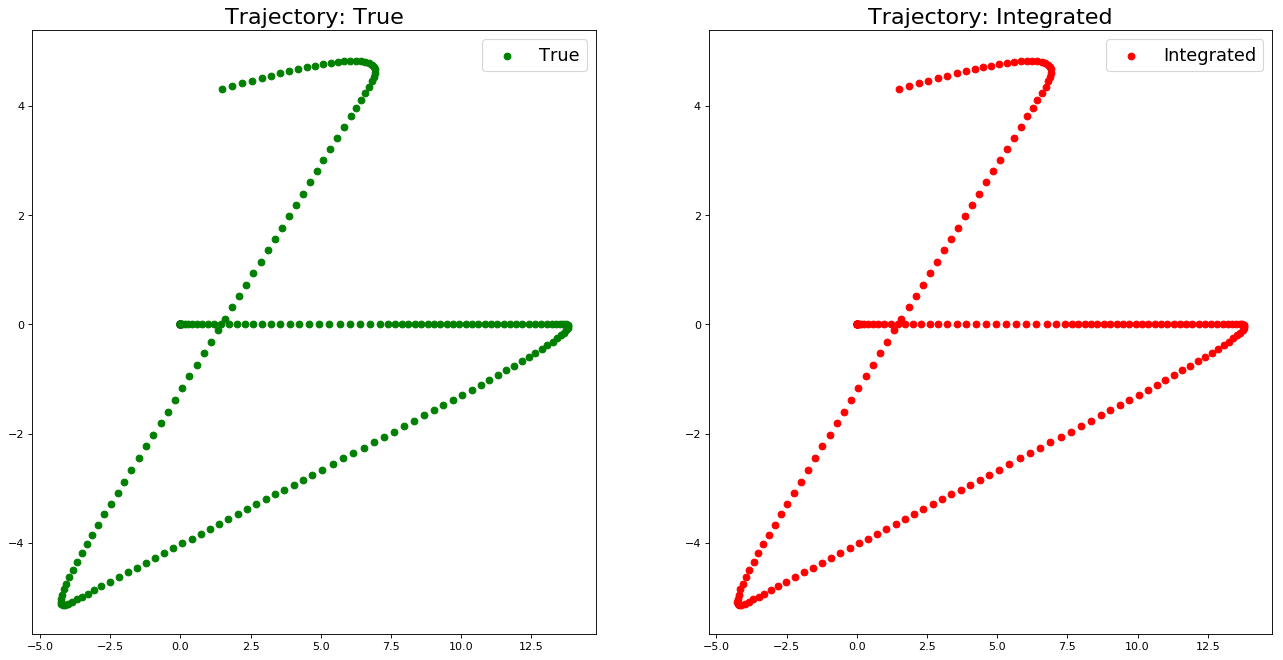

In [13]:
gen2 = integrateTrajectoryVelocityBody(position=dataset.loc[0, ['x', 'y', 'z']].values,
                                       orientation=Quaternion(dataset.loc[0, ['scalar', 'i', 'j', 'k']].values),
                                       linearVelocities=y[['dXB', 'dYB', 'dZB']].values,
                                       angularVelocities=y[['dRoll', 'dPitch', 'dYaw']].values,
                                       frequency=frequency * np.ones((plot_limit, )))

plt.figure(num=None, figsize=(20, 10), dpi=80, facecolor='w', edgecolor='k')

for i in range(1, plot_limit):
    # ------------------
    plt.subplot(1, 2, 1)
    plt.legend(['True'], fontsize=16)
    plt.title('Trajectory: True', fontdict={'fontsize':20})
    
    pTrue = dataset.loc[i, ['x', 'y', 'z']]
    oTrue = dataset.loc[i, ['roll', 'pitch', 'yaw']]
    plt.scatter(pTrue[0], pTrue[1], color='green')
    
    # -----------------
    plt.subplot(1, 2, 2)
    plt.legend(['Integrated'], fontsize=16)
    plt.title('Trajectory: Integrated', fontdict={'fontsize':20})
    
    o, p, _, _ = next(gen2)
    plt.scatter(p[0], p[1], color='red') 
    
    try:
        assert(np.allclose(p.astype(np.float64), pTrue.astype(np.float64)))
    except:
        print('Unit test failed! at: {} after {} seconds'.format(i, int(i/frequency)))
        break
    
    if i == plot_limit - 1:
        print('Unit test passed!!')

# Data Exploration 
units are m/s and rad/s

In [14]:
dataset[X.columns[:-4]].describe()

,dXB,dYB,dZB,dRoll,dPitch,dYaw,roll,pitch
count,35631.000000,3.563100e+04,35631.000000,3.563100e+04,3.563100e+04,3.563100e+04,3.563100e+04,35631.000000
mean,1.236594,-6.366326e-02,-0.018494,2.915434e-03,1.032342e-02,1.004484e-01,-4.327812e-04,-0.050988
std,1.533166,1.099391e+00,0.159844,1.981654e-01,7.201617e-01,6.046432e-01,5.461011e-02,0.134256
min,-3.668039,-3.766173e+00,-4.311520,-2.628738e+00,-2.636145e+00,-1.221726e+00,-3.349788e-01,-0.529564
25%,0.024507,-2.775676e-01,-0.094820,-8.941799e-04,-3.243105e-03,-9.013697e-06,-2.343596e-04,-0.126941
50%,1.228610,-3.362917e-07,-0.002188,-6.488956e-08,3.928297e-07,1.114709e-07,2.762088e-09,-0.000215
75%,2.504733,1.710126e-01,0.029799,7.616148e-04,1.308315e-01,1.896088e-01,3.021388e-04,0.000135
max,3.903385,3.770765e+00,1.028721,2.509661e+00,2.630245e+00,1.221726e+00,3.374339e-01,0.353618


## Distribution of actions

In [15]:
action_counts = dataset['aName'].value_counts()


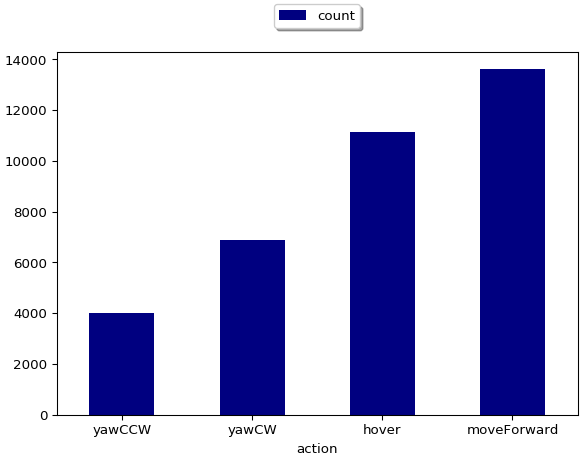

In [16]:
display(pd.DataFrame({'action':a, 'count':c} for a, c in action_counts.to_dict().items()))

## Data Ranges


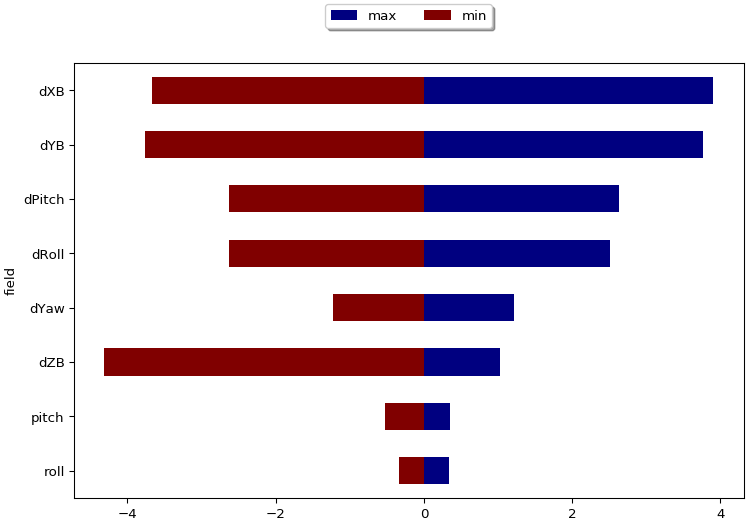

In [17]:
ranges = dataset[X.columns[:-4]].describe()
max_min = pd.DataFrame({'field':a, 'max':c['max'], 'min':c['min']} for a, c in ranges.to_dict().items())
display(max_min)

# Velocity based models

In [18]:
from sklearn.metrics import mean_squared_error
from sklearn.multioutput import MultiOutputRegressor

### MLP Regressor with grid-search and cross-validation

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor

parameters = {'hidden_layer_sizes':[(12, ), (24, ), (80, )], 'alpha':np.geomspace(1e-4, 1e4, 10)}
clf = GridSearchCV(MLPRegressor(max_iter=int(10e3), random_state=10), parameters, n_jobs=-1).fit(xTrain, yTrain)

mlp_cv = clf.best_estimator_

In [20]:
mlp_cv

MLPRegressor(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(80,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=10, shuffle=True,
       solver='adam', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [21]:
yPredicted = pd.DataFrame(mlp_cv.predict(xTest), columns=y.columns)
    
mlp = MLPRegressor(hidden_layer_sizes=clf.best_params_['hidden_layer_sizes'],
                   alpha=clf.best_params_['alpha'], max_iter=int(10e8), random_state=10).fit(X, y)

#### MLP RMSE units are meter/sec and deg/sec

In [22]:
for i, c in enumerate(y.columns):
    error = (mean_squared_error(yPredicted[c], yTest[c]) ** 0.5)
    print(c + '\t', np.rad2deg(error) if i > 2 else error)

dXB	 0.0503648849583
dYB	 0.0371446422488
dZB	 0.0474599297303
dRoll	 3.11583626811
dPitch	 4.81541412833
dYaw	 2.87293971687


### Gradient Boost  Trees

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

In [24]:
gradient = MultiOutputRegressor(GradientBoostingRegressor(max_depth=8, loss='huber'))\
          .fit(xTrain, yTrain)

#### Gradient Boost RMSE units are meter/sec and deg/sec

In [25]:
yPredicted = pd.DataFrame(gradient.predict(xTest), columns=y.columns)
for i, c in enumerate(y.columns):
    error = (mean_squared_error(yPredicted[c], yTest[c]) ** 0.5)
    print(c + '\t', np.rad2deg(error) if i > 2 else error)

dXB	 0.0353875571249
dYB	 0.0257421715715
dZB	 0.016445505122
dRoll	 2.82254088206
dPitch	 2.3024128811
dYaw	 1.03951086227


In [26]:
def predict(actions, position, orientation, x0, model, frequency=10, limit=100):
    for i in range(0, limit):
        if i > 0:
            roll, pitch, yaw = toEulerianAngle(orientation)
            x0 = np.concatenate((linearVelocity, angularVelocity, [roll, pitch] , actions[i]))
            
        s1 = model.predict(x0.reshape(1, -1)).reshape(6,)
        
        orientation, position, linearVelocity, angularVelocity=\
        next(integrateTrajectoryVelocityBody(position=position, orientation=orientation,
                                             frequency=[frequency],
                                             linearVelocities=[s1[[0, 1, 2]]],
                                             angularVelocities=[s1[[3, 4, 5]]]))
        yield orientation, position

## Integrated trajectories of random samples from test dataset (10 seconds each)

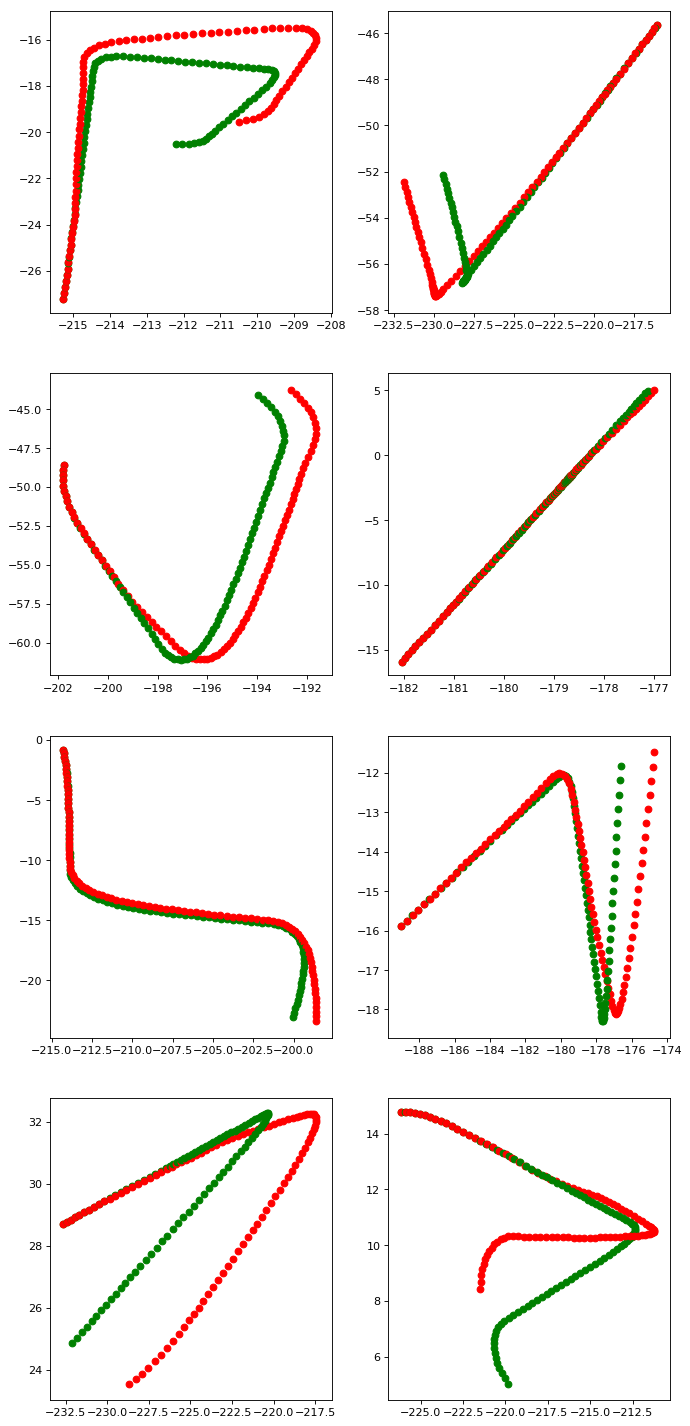

In [27]:
plt.figure(num=None, figsize=(10, 23), dpi=80, facecolor='w', edgecolor='k')

limit = 100

for j in range(1, 9):
    shift = np.random.randint(xTest.shape[0]-limit)

    actions = xTest[['moveForward', 'yawCCW', 'yawCW', 'hover']].values[shift:]
    position = dataset.loc[train + shift, ['x', 'y', 'z']].values
    orientation = Quaternion(dataset.loc[train + shift, ['scalar', 'i', 'j', 'k']].values)

    gen2 = predict(position=position, orientation=orientation, x0=xTest.iloc[shift].values, 
               actions=actions, limit=limit, model=gradient)
    
    for i in range(1, limit):
        plt.subplot(4, 2, j)
        pTrue = dataset.loc[i+train+shift, ['x', 'y', 'z']]
        o, p = next(gen2)

        plt.scatter(*pTrue[:-1], color='green')
        plt.scatter(p[0], p[1], color='red')

In [28]:
# taken from: https://stackoverflow.com/questions/4633177/c-how-to-wrap-a-float-to-the-interval-pi-pi
def wrapAroundPi(angle):
    return np.arctan2(np.sin(angle), np.cos(angle))

def getOrientationErrorGlobal(angularPosition1, angularPosition0, frequency):
    return getAverage(m1=angularPosition1, m0=angularPosition0, frequency=frequency, wrap=wrapAngleAroundPi)

In [37]:
pos_error = np.ones((limit, 3))
orientation_error = np.ones((limit, 3))

shift = np.random.randint(xTest.shape[0]-limit)

actions = xTest[['moveForward', 'yawCCW', 'yawCW', 'hover']].values[shift:]
position = dataset.loc[train + shift, ['x', 'y', 'z']].values
orientation = Quaternion(dataset.loc[train + shift, ['scalar', 'i', 'j', 'k']].values)

gen2 = predict(position=position, orientation=orientation, x0=xTest.iloc[shift].values, 
           actions=actions, limit=limit, model=gradient)

for i in range(1, limit):
    pTrue = dataset.loc[i+train+shift, ['x', 'y', 'z']]
    oTrue = dataset.loc[i+train+shift, ['scalar', 'i', 'j', 'k']]
    o, p = next(gen2)
    pos_error[i -1] = p - pTrue
    orientation_error[i -1] = getOrientationErrorGlobal(toEulerianAngle(o) ,toEulerianAngle(oTrue), 1.0)

## Error in position across (10 seconds)


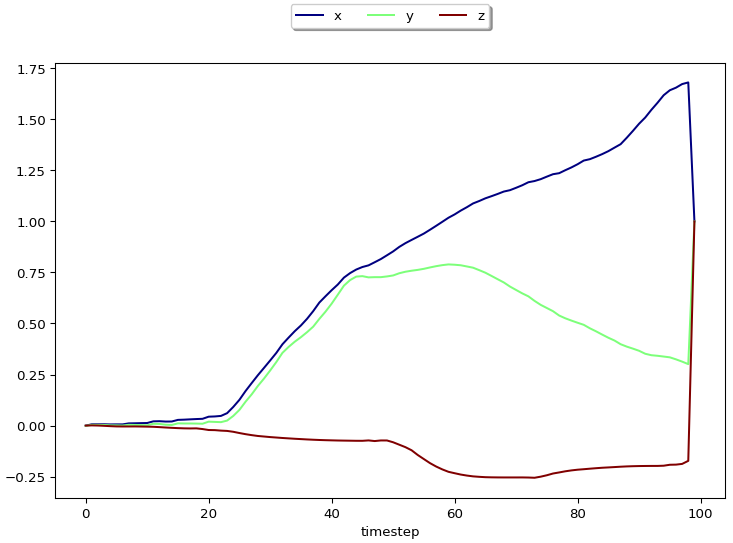

In [38]:
error = pd.DataFrame(pos_error, columns=['x', 'y', 'z'])
error['timestep'] = error.index
display(error)

## Error in Orientation (smallest angle) in radians (10 seconds)


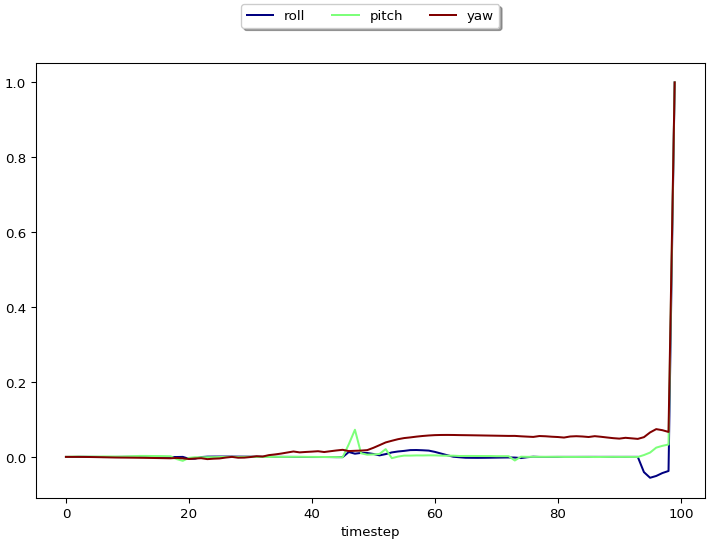

In [42]:
error = pd.DataFrame(orientation_error, columns=['roll', 'pitch', 'yaw'])
error['timestep'] = error.index
display(error)

# 2D Model Verification (pygame)

obtained model is used in a simulated environment, and controlled manually

<img src='learned_model.gif'>

# Model successfully captures multirotor dynamics!!

In [95]:
joblib.dump(gradient, '../models/gradient.model')

['../models/gradient.model']

In [776]:
joblib.dump(mlp, '../models/nn.model')

['../models/nn.model']